# Udacity Self-Driving Car Nanodegree

## Advanced Lane Finding Project

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images (Calibrating a Camera.ipynb)
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
#Imports
import pickle
import numpy as np
import cv2
import os, os.path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from moviepy.editor import VideoFileClip

%matplotlib inline

# 1. Camera calibration

This would be the first step where we will try to calibrate the camera in order to deal with the distorsions of 3D objects when mapped into a 2D image. That transformation isn't perfect, so the original size ans shape of an object may be changed. The code for this part can be found at [camera calibration]().

In [2]:
#PATHS
#Camera calibration information folder path
calibration_path = './data/camera_calibration_params.p'
testImg_path = './test_images/'

#Reading the camera matrix and distortion coefficients
calibration = pickle.load(open(calibration_path, "rb"))
mtx = calibration["mtx"]
dist = calibration["dist"]

print("Camera calibration information readed successfully!")

valid_images = [".jpg"]
imgs_original = {}

#Loading the images
for file in os.listdir(testImg_path):
    img_name = os.path.splitext(file)[0]
    img_ext = os.path.splitext(file)[1]
    
    if img_ext.lower() not in valid_images:
        continue
    
    #RGB images loaded
    imgs_original[img_name] = mpimg.imread(testImg_path + file)
    
print("We successfully loaded {} images.".format(len(imgs_original)))

Camera calibration information readed successfully!
We successfully loaded 8 images.


### 1.1 Plotting the original images

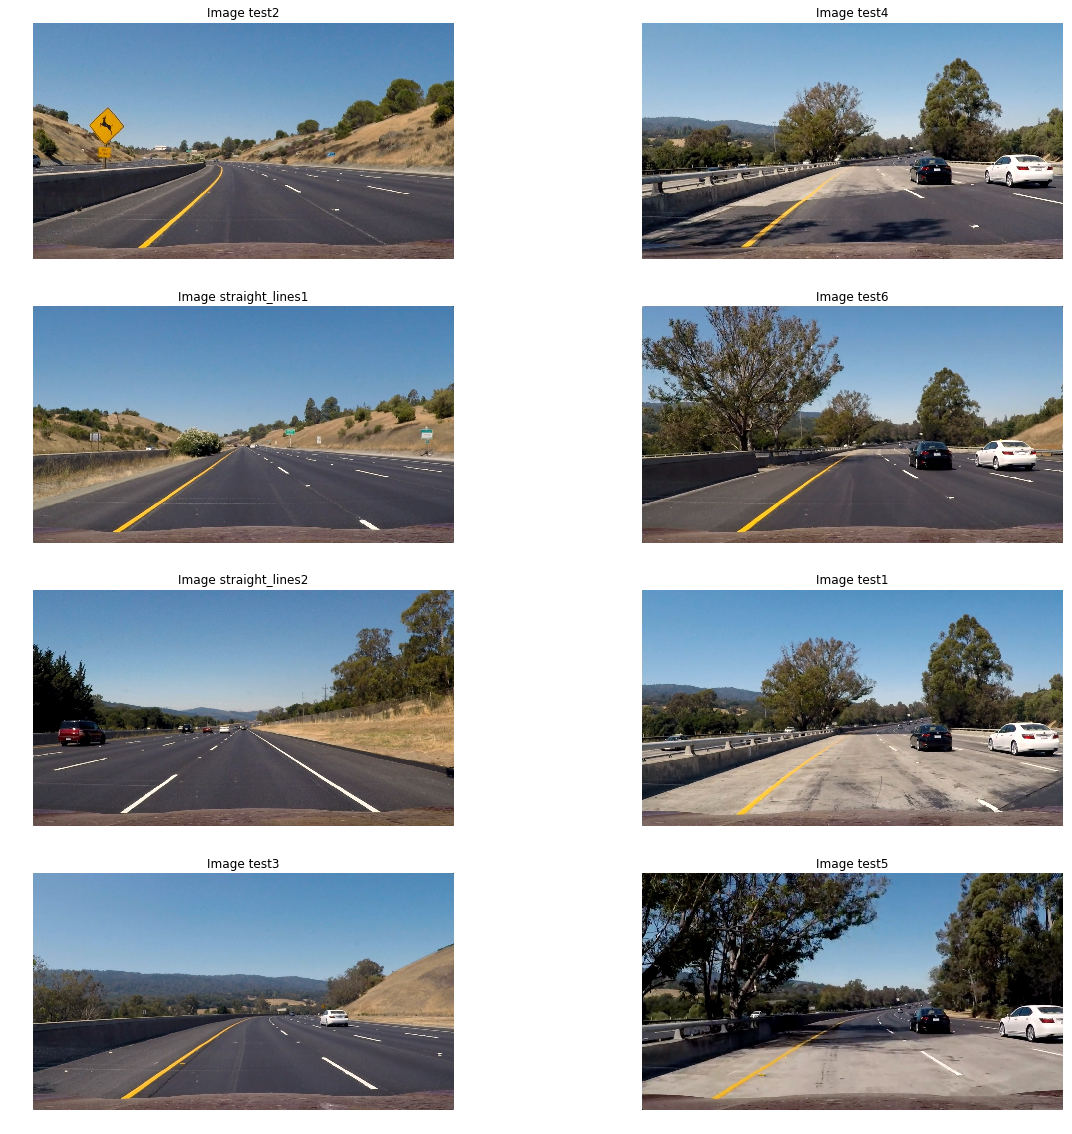

In [3]:
#Plot original images
figure = plt.figure(figsize= (20, 20))
index = 1
for name in imgs_original.keys():
    figure.add_subplot(4, 2, index)
    plt.title("Image {}".format(name))
    plt.imshow(imgs_original[name])
    plt.axis('off')
    index += 1
    
plt.savefig("output_images/original_images.png")

# 2. Distortion correction

In [4]:
#Undistort all images
imgs_undistorted = {}

for key, image in imgs_original.items():
    imgs_undistorted[key] = cv2.undistort(image, mtx, dist, None, mtx)

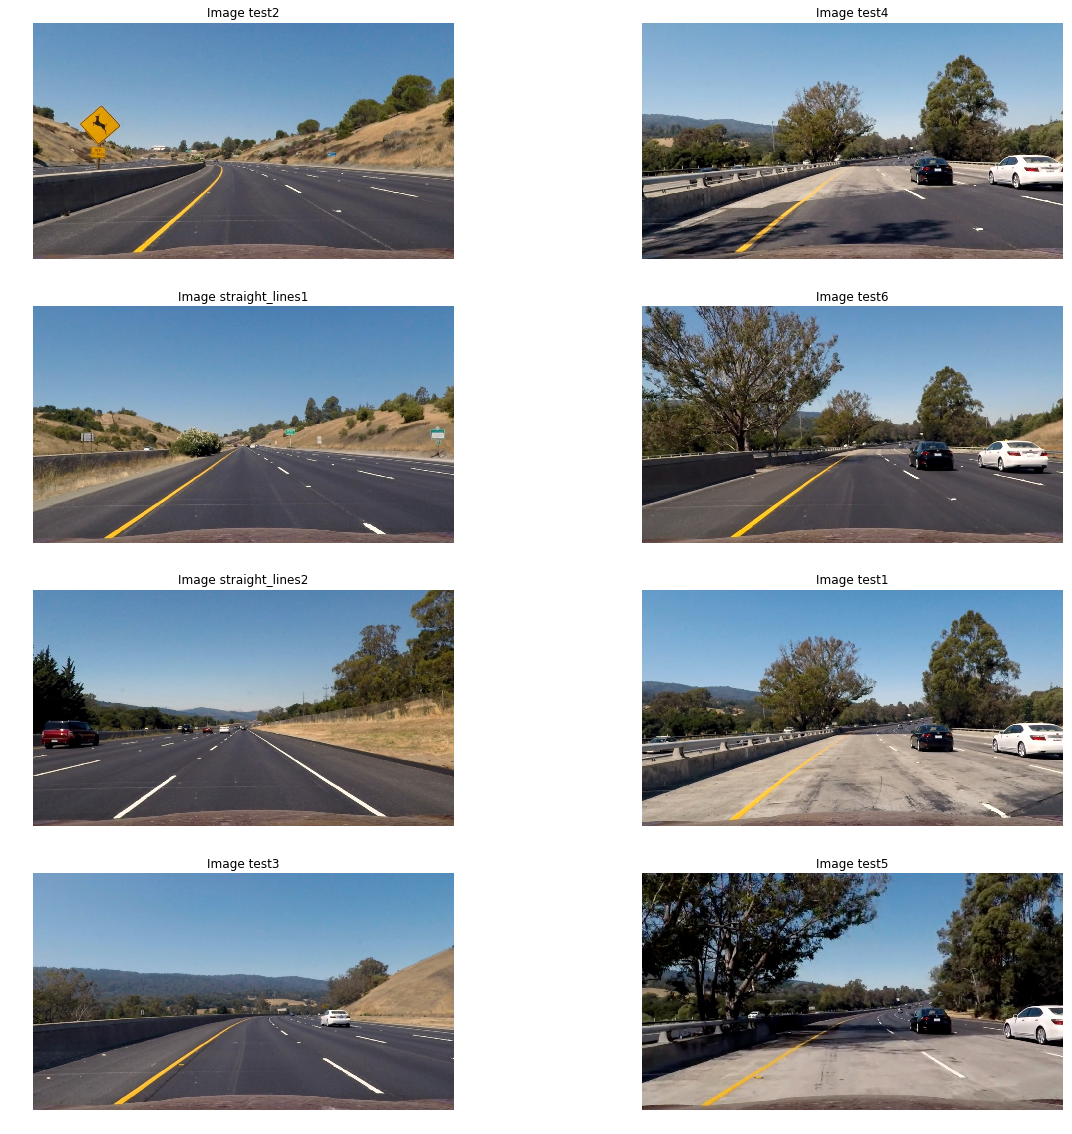

In [5]:
#Plot all undistorted images
figure = plt.figure(figsize= (20, 20))
index = 1

for key, image in imgs_undistorted.items():
    figure.add_subplot(4, 2, index)
    plt.title("Image {}".format(key))
    plt.imshow(image)
    plt.axis('off')
    index += 1
    
plt.savefig("output_images/undistorted_images.png")

## Distorted image vs undistorted image

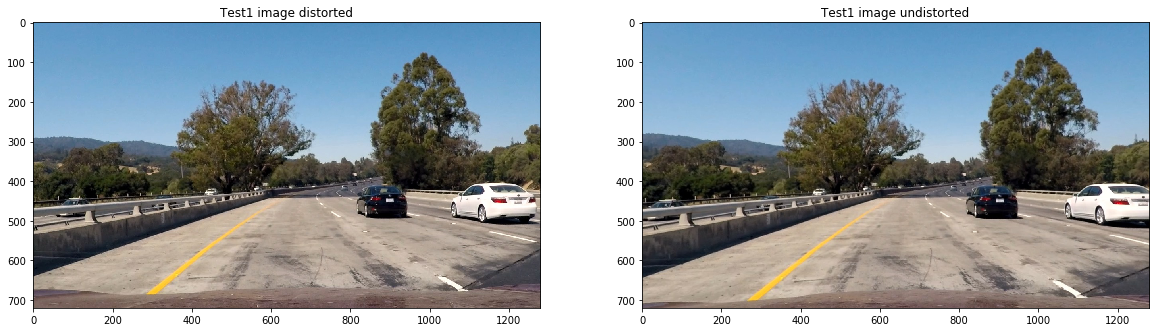

In [6]:
#We will plot an original image at left and the same undistorted image at right
figure = plt.figure(figsize=(20, 20))

figure.add_subplot(1, 2, 1)
plt.imshow(imgs_original['test1'])
plt.title("Test1 image distorted")

figure.add_subplot(1, 2, 2)
plt.imshow(imgs_undistorted['test1'])
plt.title("Test1 image undistorted")

print()
plt.savefig("output_images/original_vs_undistorted.png")

# 3. Color/gradient threshold

In [7]:
#Image preprocessing: HLS color space. Expected conversion from RGB to RGB
def RGB_to_HLS(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)

#Binarize an input image by using min and max threshold values as a tuple (min_thresh, max_thresh)
def binarize_image(image, thresh= (0, 255)):
    binary_img = np.zeros_like(image)
    binary_img[(image > thresh[0]) & (image <= thresh[1])] = 1
    return binary_img

#Gaussian blur for noise removal
def gaussian_blur (img, kernel_size = 3):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

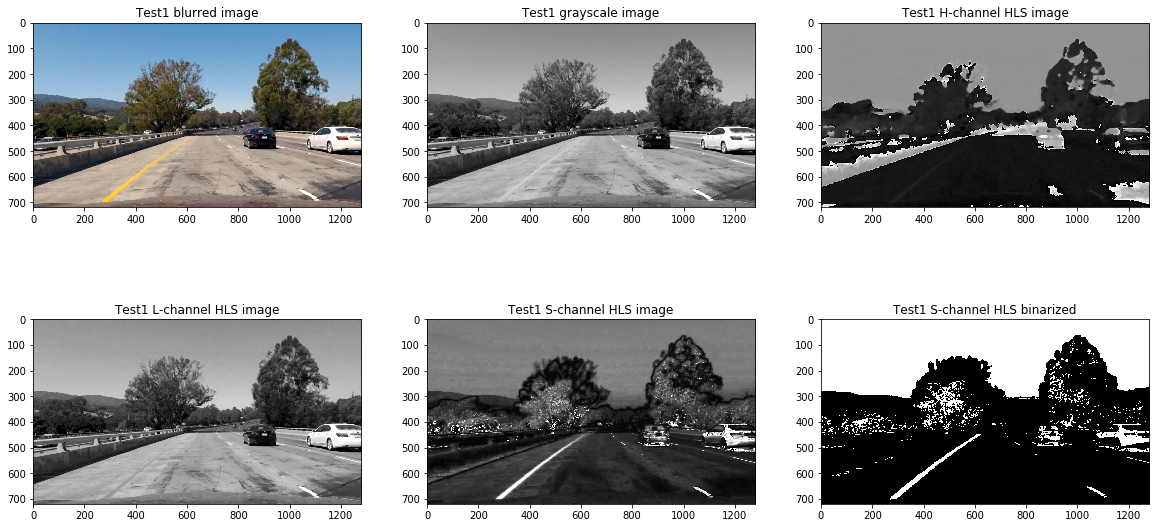

In [8]:
#Testing HLS color space and also grayscale in order to select the best color space for this problem
figure = plt.figure(figsize= (20,10))

figure.add_subplot(2,3,1)
plt.imshow(imgs_undistorted["test1"])
plt.title("Test1 blurred image")

#GRAYSCALE IMAGE
gray_image = cv2.cvtColor(imgs_undistorted["test1"], cv2.COLOR_RGB2GRAY)
figure.add_subplot(2,3,2)
plt.imshow(gray_image, cmap='gray')
plt.title("Test1 grayscale image")

#HLS IMAGE -> H channel
hls_image = RGB_to_HLS(imgs_undistorted["test1"])
hls_image_h = hls_image[:,:,0]
figure.add_subplot(2,3,3)
plt.imshow(hls_image_h, cmap='gray')
plt.title("Test1 H-channel HLS image")

#HLS IMAGE -> L channel
hls_image_l = hls_image[:,:,1]
figure.add_subplot(2,3,4)
plt.imshow(hls_image_l, cmap='gray')
plt.title("Test1 L-channel HLS image")

#HLS IMAGE -> S channel
figure.add_subplot(2,3,5)
hls_image_s = hls_image[:,:,2]
plt.imshow(hls_image_s, cmap='gray')
plt.title("Test1 S-channel HLS image")

#S channel HLS binarized
hls_image_s_bin = binarize_image(hls_image_s, thresh=(100, 255))
figure.add_subplot(2,3,6)
plt.imshow(hls_image_s_bin, cmap='gray')
plt.title("Test1 S-channel HLS binarized")

plt.savefig("output_images/color_space_images.png")
print()

As we can see. The S-channel of the HLS image highlight the road lines much more than the other channels of the HLS image and the grayscale image which results are quite poor. Moreover, by binarizing the S-channel HLS image we obtain good results avoiding at the same time a lot of noise.

### 3.1 Applying sobel

In [9]:
#Sobel filter. We can choose gradient orientation (orient) and min/max thresholds
#The input image need to be already converted to the color space we want to use
def abs_sobel_thresh(img, thresh, sobel_kernel=3, orient='x'):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

#### 3.1.1 Testing sobel

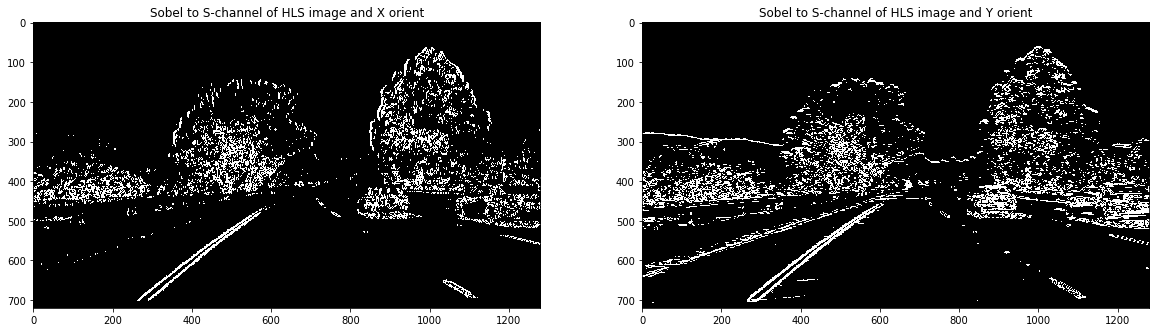

In [10]:
test_sobel_img = RGB_to_HLS(imgs_undistorted["test1"])

abs_bin_sobel_x = abs_sobel_thresh(test_sobel_img[:,:,2], thresh=(20, 120), sobel_kernel=5, orient='x')
abs_bin_sobel_y = abs_sobel_thresh(test_sobel_img[:,:,2], thresh=(20, 120), sobel_kernel=5, orient='y')

#Plot results
figure = plt.figure(figsize= (20,10))
figure.add_subplot(1,2,1)
plt.imshow(abs_bin_sobel_x, cmap='gray')
plt.title("Sobel to S-channel of HLS image and X orient")
figure.add_subplot(1,2,2)
plt.imshow(abs_bin_sobel_y, cmap='gray')
plt.title("Sobel to S-channel of HLS image and Y orient")

plt.savefig("output_images/sobel_thresh.png")
print()

We can notice that in this case the best choice would be a sobel filter on X axis orientation using a minimum threshold of 40 and a maximum of 100 with a kernel size of 11. On Y axis orientation the difference would be the minimum threshold which will be 60

### 3.2 Magnitude of the Gradient

In [11]:
#This function firstly applies sobel and then computes the magniude of the gradient
#It also outputs a binary result with a thresholding operation
#We expect the input img already converted to the desired color space
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#### 3.2.1 Testing magnitude of the gradient

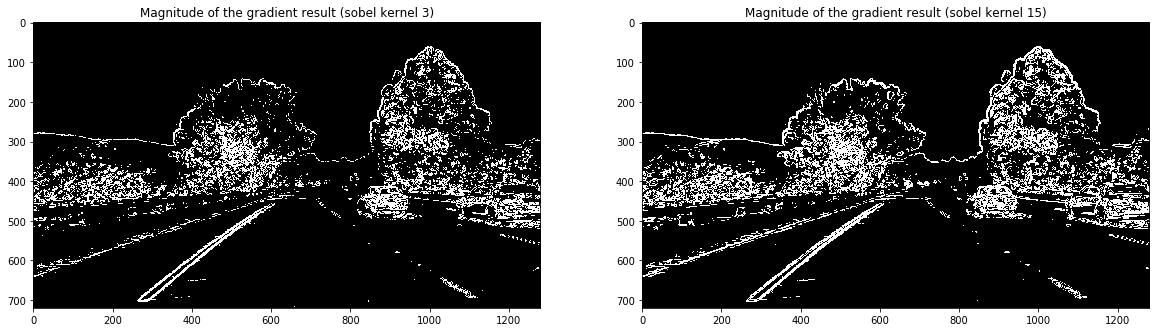

In [12]:
test_gradMagn_img = RGB_to_HLS(imgs_undistorted["test1"])

mag_thresh_test1 = mag_thresh(test_gradMagn_img[:,:,2], sobel_kernel= 3, thresh=(20,100))
mag_thresh_test2 = mag_thresh(test_gradMagn_img[:,:,2], sobel_kernel= 5, thresh=(20,100))

figure = plt.figure(figsize= (20,10))

figure.add_subplot(1,2,1)
plt.imshow(mag_thresh_test1, cmap='gray')
plt.title("Magnitude of the gradient result (sobel kernel 3)")

figure.add_subplot(1,2,2)
plt.imshow(mag_thresh_test2, cmap='gray')
plt.title("Magnitude of the gradient result (sobel kernel 15)")

plt.savefig("output_images/magn_grad_thresh.png")
print()

### 3.3 Direction of the gradient

In [13]:
# This function computes the direction of the gradient appying a threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#### Testing direction of the gradient

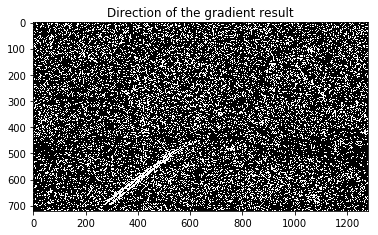

In [14]:
test_dirGrad_img = RGB_to_HLS(imgs_undistorted["test1"])

dir_threshold_test = dir_threshold(test_dirGrad_img[:,:,2], sobel_kernel= 7, thresh=(0.7, 1.1))

plt.imshow(dir_threshold_test, cmap='gray')
plt.title("Direction of the gradient result")

plt.savefig("output_images/dir_grad_thresh.png")

print()

### 3.4 Combining thresholds

In [15]:
imgs_thresholded = {}

for key, image in imgs_undistorted.items(): 
    # Apply each of the thresholding functions
    image_hls = RGB_to_HLS(image)
    
    gradx = abs_sobel_thresh(image_hls[:,:,2], thresh=(20,120), sobel_kernel=5, orient='x')
    grady = abs_sobel_thresh(image_hls[:,:,2], thresh=(20,120), sobel_kernel=5, orient='y')
    mag_binary = mag_thresh(image_hls[:,:,2], sobel_kernel= 3, thresh=(20,100))
    dir_binary = dir_threshold(image_hls[:,:,2], sobel_kernel= 7, thresh=(0.6, 1.4))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    imgs_thresholded[key] = combined

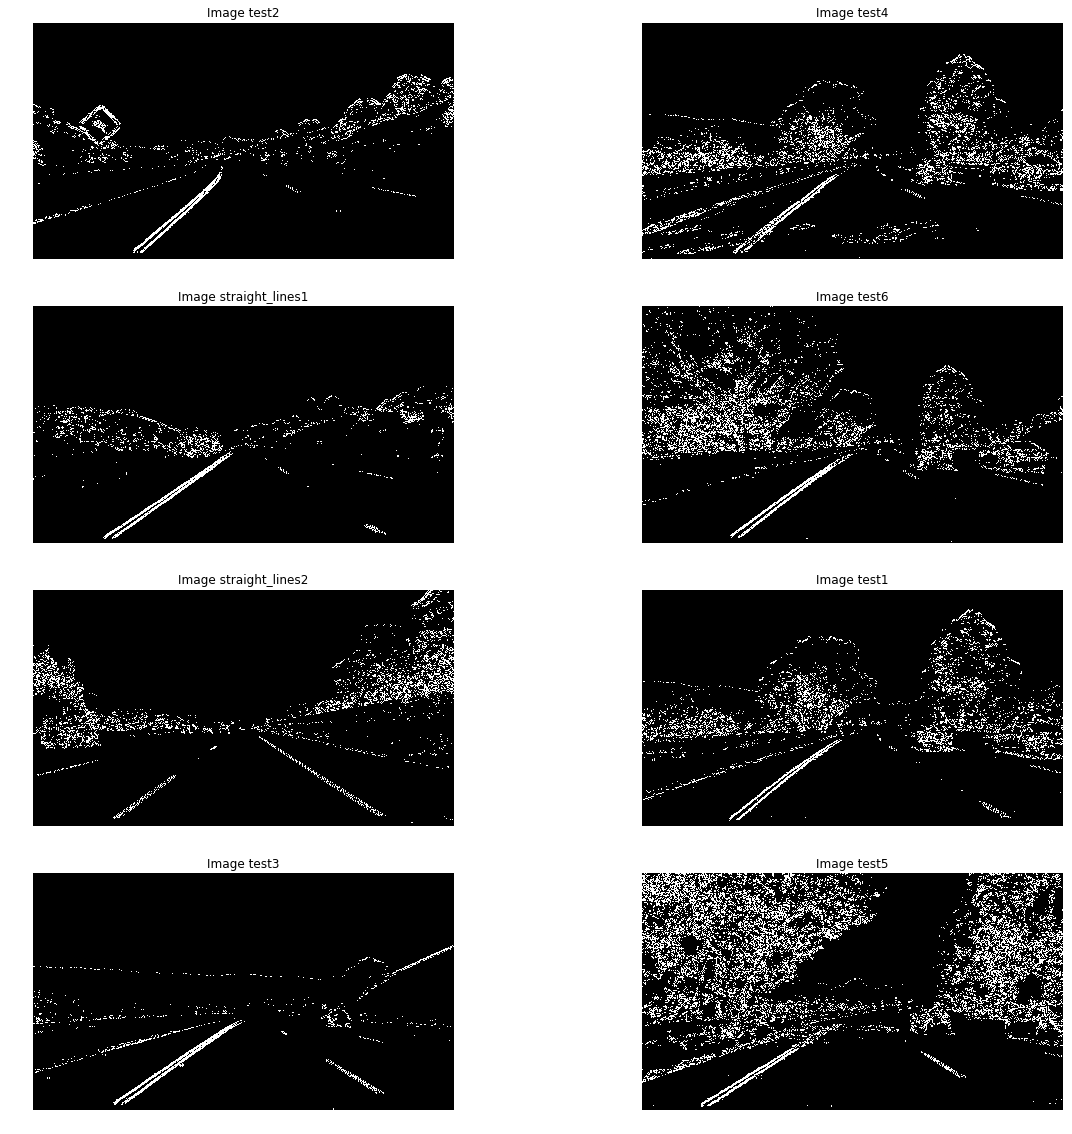

In [16]:
#Plot all thresholded images
figure = plt.figure(figsize= (20, 20))
index = 1

for key, image in imgs_thresholded.items():
    figure.add_subplot(4, 2, index)
    plt.title("Image {}".format(key))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    index += 1
    
plt.savefig("output_images/combined_thresh.png")

The results have a lot of noise. This indicates that the combination of all thresholds is not the best choice.

REVIEW 1: 

I encourage you to continue trying other color spaces to isolate the yellows and whites. Try thresholding L of Luv for whites and b of Lab for yellows. By better identifying yellows and whites, the pipeline can rely less on (or avoid entirely) gradients. This is especially important and helpful for dealing with shadows and variations in the road lighting and appearance. R and V are also strong components of whites and yellows.

In [17]:
def suggested_threshold(img, s_thresh, l_thresh, b_thresh):
    s_channel= cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel= cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel= cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
    
    s_binary= np.zeros_like(s_channel) 
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (s_binary == 1)] = 1
    
    return combined_binary

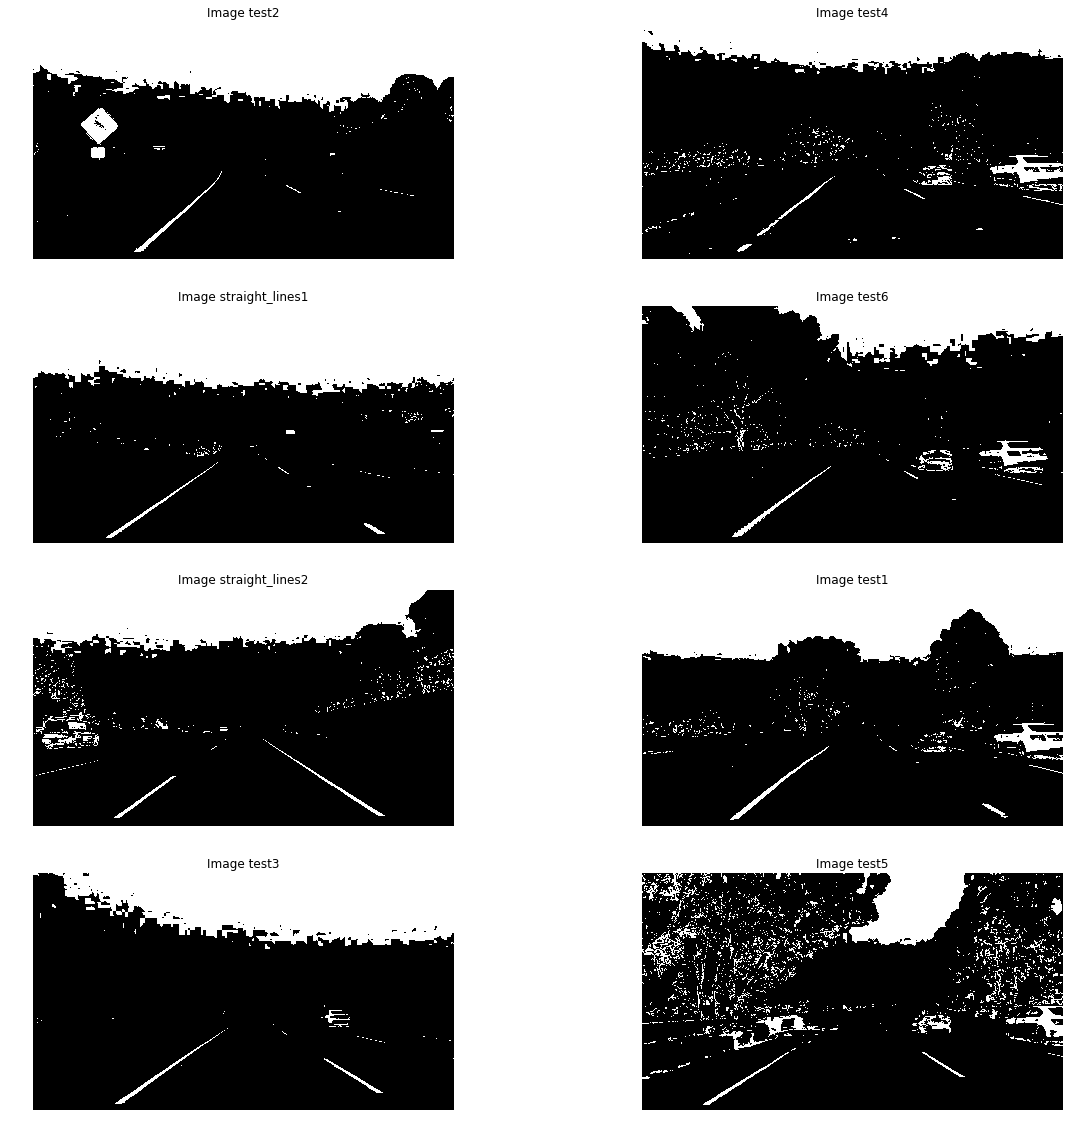

In [18]:
suggested_thresholded_imgs = {}

s_thresh = [180, 255]
l_thresh = [225, 255]
b_thresh = [155, 200]

for key, image in imgs_undistorted.items(): 
    output = suggested_threshold(image, s_thresh, l_thresh, b_thresh)
    suggested_thresholded_imgs[key] = output
    

#Plot all thresholded images
figure = plt.figure(figsize= (20, 20))
index = 1

for key, image in suggested_thresholded_imgs.items():
    figure.add_subplot(4, 2, index)
    plt.title("Image {}".format(key))
    plt.imshow(suggested_thresholded_imgs[key], cmap='gray')
    plt.axis('off')
    index += 1
    
plt.savefig("output_images/suggested_thresholded.png")

# 3. Perspective transform

In [19]:
#Define perspective transform function
def perspective_transform(in_img, in_src_points, in_dst_points):
    
    src = np.float32(in_src_points)
    dst = np.float32(in_dst_points)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(in_img, M, (in_img.shape[1], in_img.shape[0]))

    return warped, M, Minv

def warp_perspective(in_img, M, Minv):
    return cv2.warpPerspective(in_img, M, (in_img.shape[1], in_img.shape[0]))
    
def draw_rect(in_img, in_points):
    output_img = in_img.copy()
    
    cv2.line(output_img, tuple(in_points[0]), tuple(in_points[1]), [0, 0, 255], 8)
    cv2.line(output_img, tuple(in_points[1]), tuple(in_points[2]), [0, 0, 255], 8)
    cv2.line(output_img, tuple(in_points[2]), tuple(in_points[3]), [0, 0, 255], 8)
    cv2.line(output_img, tuple(in_points[3]), tuple(in_points[0]), [0, 0, 255], 8)

    return output_img

### 3.1 Perspective transform test

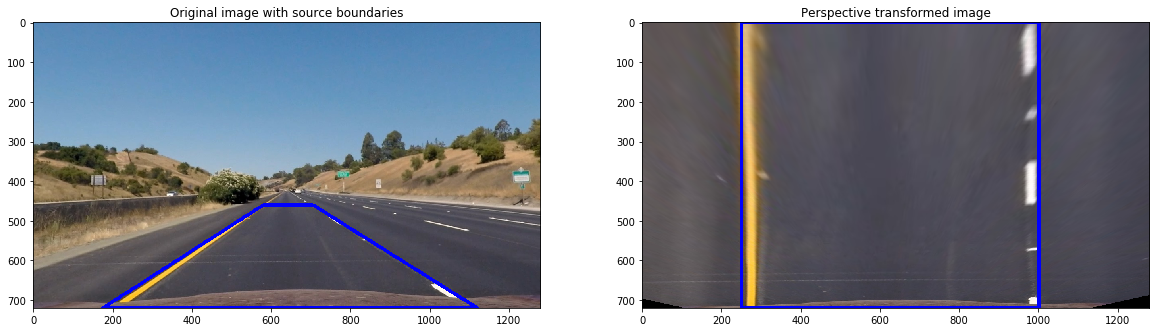

In [20]:
test_perspTran_img = imgs_undistorted["straight_lines1"]

src_tl = [580, 460]
src_tr = [705, 460]
src_br = [1120, 720]
src_bl = [175, 720]

dst_tl = [250, 0]
dst_tr = [1000, 0]
dst_br = [1000, 720]
dst_bl = [250, 720]

src_points = [src_tl, src_tr, src_br, src_bl]
dst_points = [dst_tl, dst_tr, dst_br, dst_bl]

img_perspective, M, Minv = perspective_transform(test_perspTran_img, src_points, dst_points)

perspective_trans = {}
perspective_trans["M"] = M
perspective_trans["Minv"] = Minv
pickle.dump(perspective_trans, open('./data/perspective_trans.p', 'wb'))

img_original_rect = draw_rect(test_perspTran_img, src_points)
img_perspective_rect = draw_rect(img_perspective, dst_points)


figure = plt.figure(figsize=(20,10))
figure.add_subplot(1,2,1)
plt.title("Original image with source boundaries")
plt.imshow(img_original_rect)

figure.add_subplot(1,2,2)
plt.title("Perspective transformed image")
plt.imshow(img_perspective_rect)

plt.savefig("output_images/perspective_trans.png")

print()

In [21]:
#Transform all test images to perspective view
imgs_perspective = {}

for key, image in imgs_thresholded.items():
    imgs_perspective[key] = warp_perspective(image, M, Minv)
    
imgs_perspective_suggested_thresh = {}

for key, image in suggested_thresholded_imgs.items():
    imgs_perspective_suggested_thresh[key] = warp_perspective(image, M, Minv)

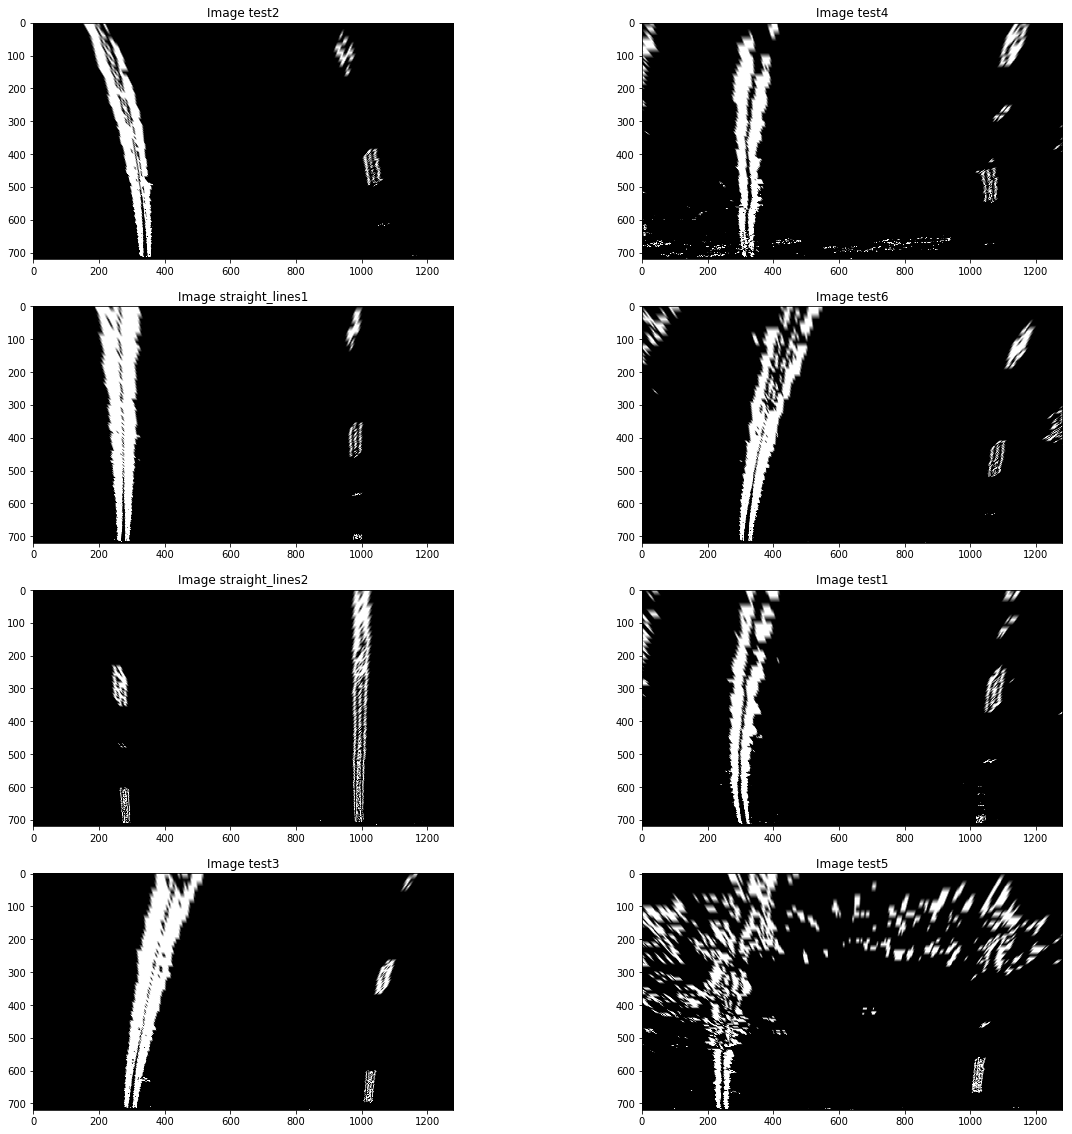

In [22]:
#Plot all perspective thresholded images
figure = plt.figure(figsize= (20, 20))
index = 1

for key, image in imgs_perspective.items():
    figure.add_subplot(4, 2, index)
    plt.title("Image {}".format(key))
    plt.imshow(image, cmap='gray')
    index += 1
    
plt.savefig("output_images/persp_thresh_trans.png")
print()

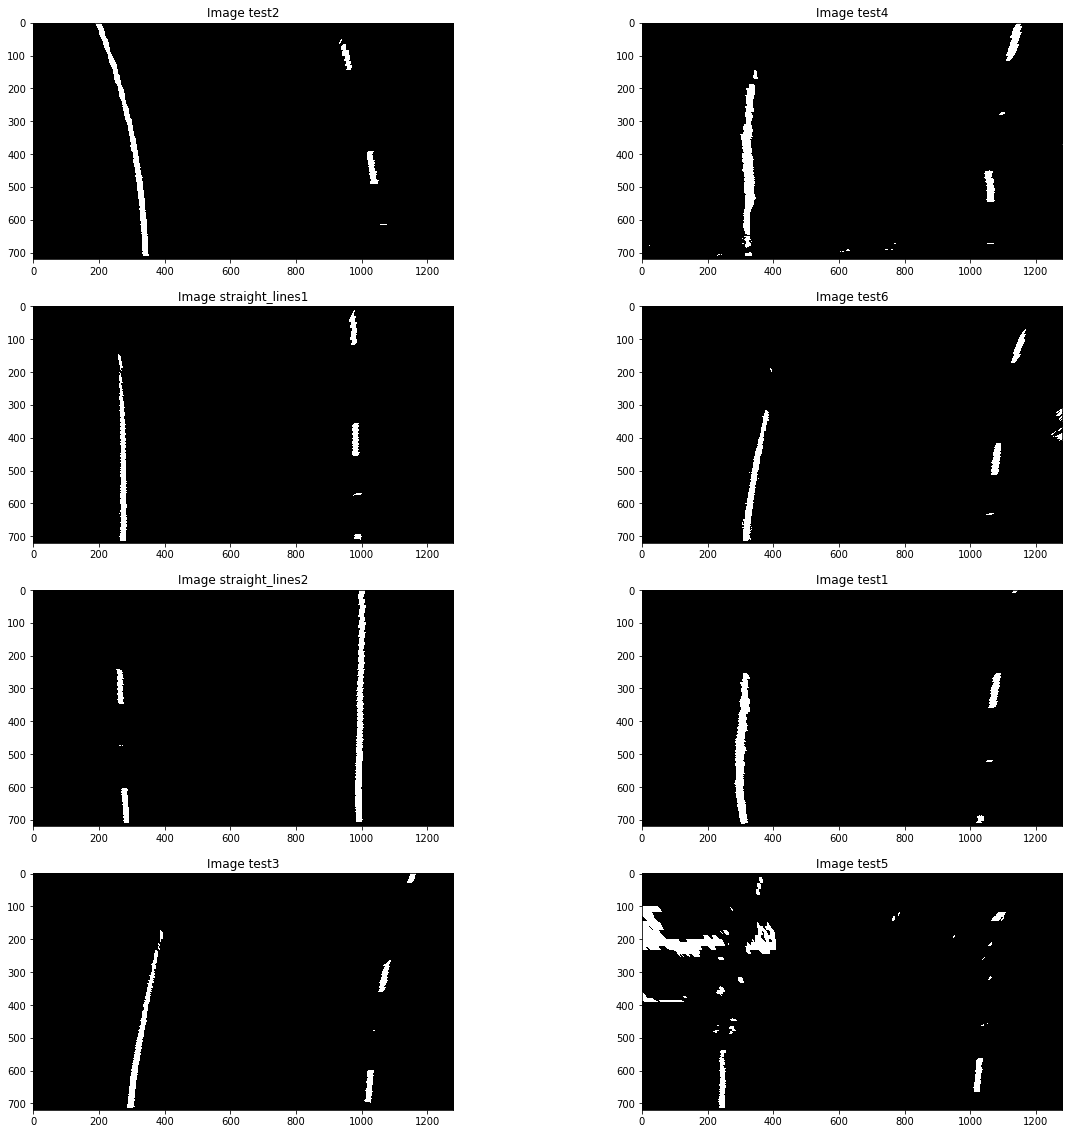

In [23]:
#Plot all perspective thresholded images according to the reviewer suggestion
figure = plt.figure(figsize= (20, 20))
index = 1

for key, image in imgs_perspective_suggested_thresh.items():
    figure.add_subplot(4, 2, index)
    plt.title("Image {}".format(key))
    plt.imshow(image, cmap='gray')
    index += 1
    
plt.savefig("output_images/persp_thresh_trans_suggested.png")
print()

imgs_perspective = imgs_perspective_suggested_thresh

# 4. Finding the lines

### 4.1 Peaks in histogram

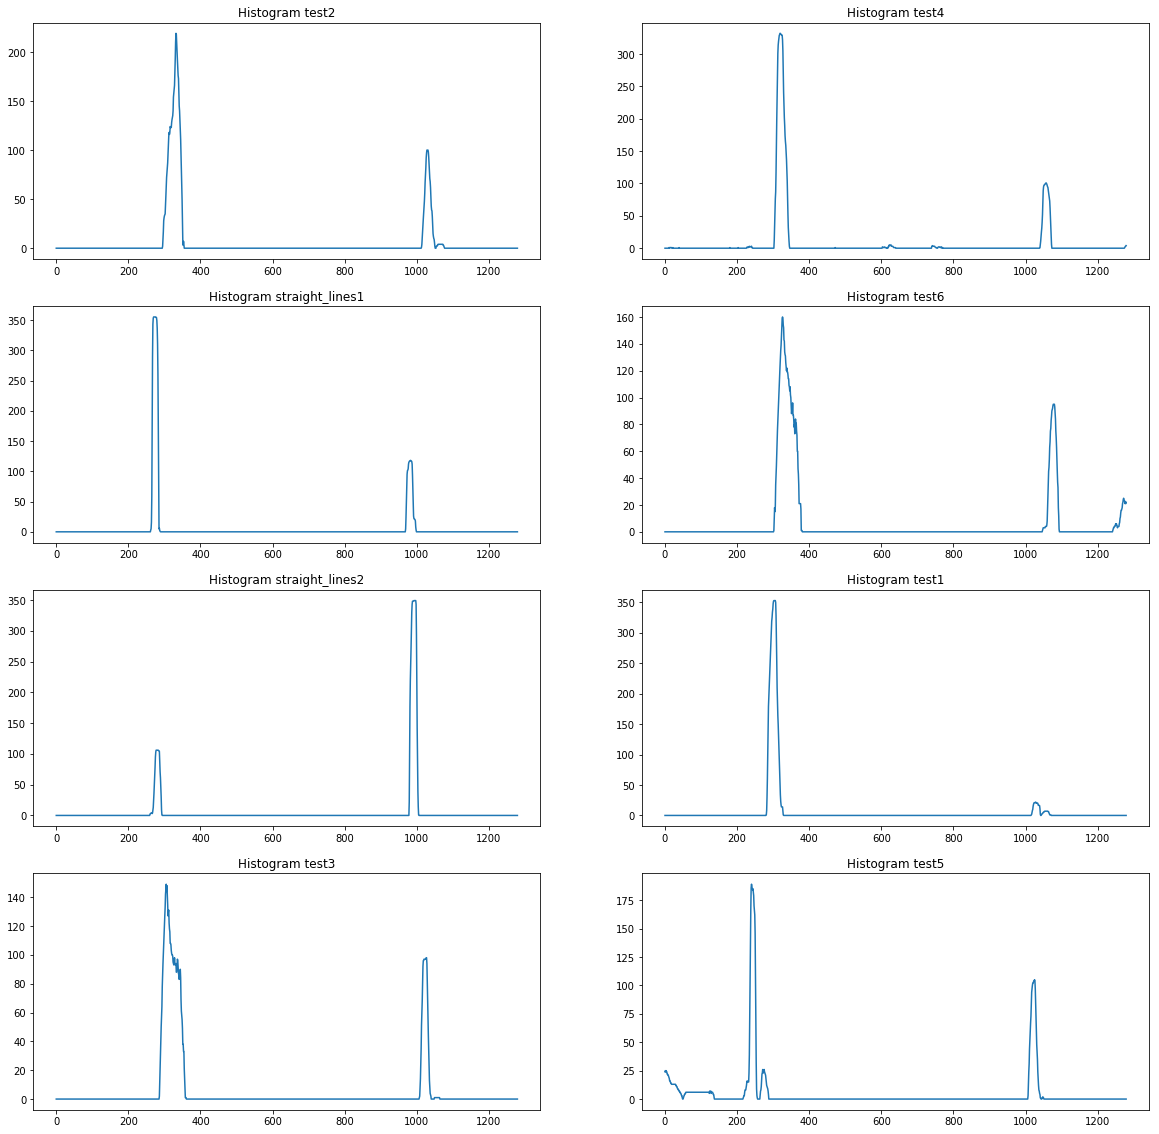

In [24]:
def get_peaks(in_img):
    curr_histogram = np.sum(in_img[in_img.shape[0]//2:, :], axis=0)
    
    return curr_histogram


histograms = {}

for key, image in imgs_perspective.items():
    histograms[key] = get_peaks(image)
    
#Plot histograms
figure = plt.figure(figsize= (20, 20))
index = 1

for key, histogram in histograms.items():
    figure.add_subplot(4, 2, index)
    plt.title("Histogram {}".format(key))
    plt.plot(histogram)
    index += 1
    
plt.savefig("output_images/histograms.png")

### 4.2 Sliding window

We can use a sliding window around the line centers (prominent peaks in the histogram) to find and follow the lines up to the top of the frame.

In [25]:
def finding_lanes(in_image):
    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(in_image.shape[0]/nwindows)
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 40
    
    # Take a histogram of the bottom half of the image
    histogram = get_peaks(in_image)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = in_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    #Visualization purposes
    rectangles = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = in_image.shape[0] - (window+1)*window_height
        win_y_high = in_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangles.append((win_xleft_low, win_y_low, win_xleft_high, win_y_high, win_xright_low, win_xright_high))
         
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, rectangles)

#### 4.2.1 Visualizing the results

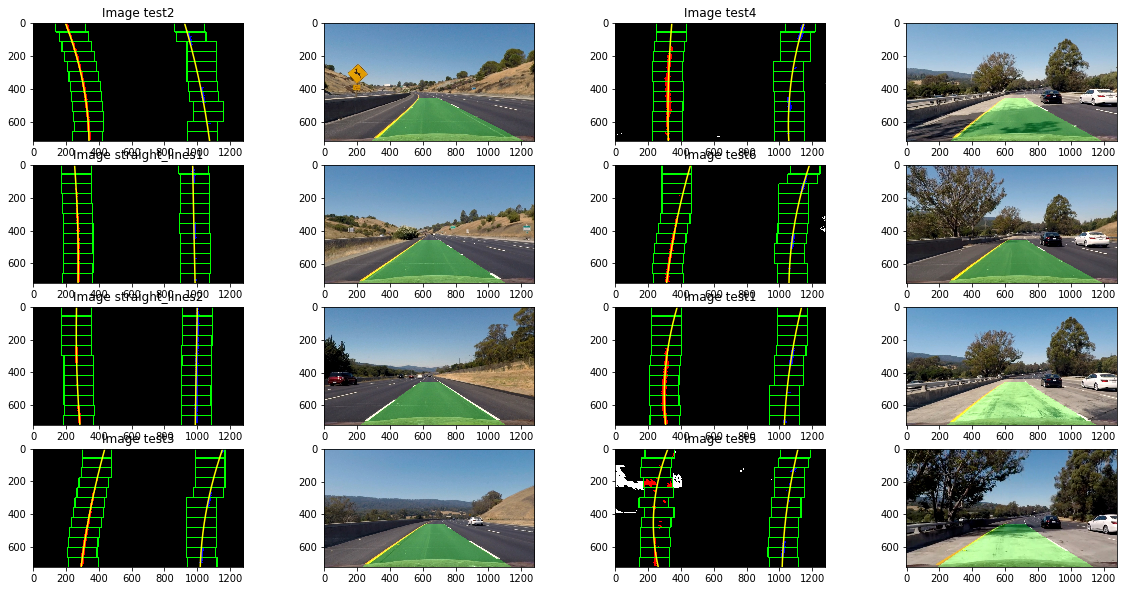

In [26]:
lanes_fit = {}

#Apply to all images and visualize
figure = plt.figure(figsize=(20,10))
index = 1
for key, image in imgs_perspective.items():
    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, rectangles = finding_lanes(image) 

    # Output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((image, image, image))*255)

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    lanes_fit[key] = (left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    for rect in rectangles:
        cv2.rectangle(out_img,(rect[0], rect[1]),(rect[2], rect[3]), (0,255,0), 5) 
        cv2.rectangle(out_img,(rect[4], rect[1]),(rect[5], rect[3]), (0,255,0), 5)
    
    figure.add_subplot(4, 4,index)
    plt.imshow(out_img)
    plt.title("Image {}".format(key))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    index += 1
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(imgs_undistorted[key], 1, newwarp, 0.3, 0)
    figure.add_subplot(4, 4, index)
    plt.imshow(result)
    
    index += 1

plt.savefig("output_images/sliding_window.png")

#### 4.2.3 Skip the sliding windows step once you know where lines are

In [27]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

def next_frame(image, lane):
    left_fit, right_fit, left_lane_inds, right_lane_inds  = lane
    
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
       
    return (left_fit, right_fit, left_lane_inds, right_lane_inds, margin)

#### 4.2.3.1 Visualization

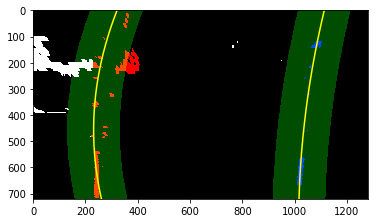

In [28]:
def visual(image, lane):
    left_fit, right_fit, left_lane_inds, right_lane_inds, margin  = lane
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((image, image, image))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result, cmap='gray')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
test_img = imgs_perspective["test5"]
next_frame_test = next_frame(image, lanes_fit["test4"])
visual(test_img, next_frame_test)

### 4.4 Measure curvature

In [29]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def compute_curvature(curve_fit, ympp= ym_per_pix, y_eval = 0):
     return ((1 + (2 * curve_fit[0] * y_eval * ympp + curve_fit[1])**2)**1.5) / np.absolute(2 * curve_fit[0])
    
for key, lane in lanes_fit.items():   
    left_fit, right_fit, left_lane_inds, right_lane_inds  = lane
    leftCurvature = compute_curvature(left_fit, y_eval = 2) / 1000
    rightCurvature = compute_curvature(right_fit, y_eval = 2) / 1000
    
    print("Image {}: left curvature {:.2f} km, right curvature {:.2f}km".format(key, leftCurvature, rightCurvature))

Image test2: left curvature 2.38 km, right curvature 5.05km
Image test4: left curvature 6.49 km, right curvature 2.31km
Image straight_lines1: left curvature 7.79 km, right curvature 178.91km
Image test6: left curvature 4.80 km, right curvature 2.66km
Image straight_lines2: left curvature 7.16 km, right curvature 158.57km
Image test1: left curvature 2.11 km, right curvature 4.01km
Image test3: left curvature 5.23 km, right curvature 2.73km
Image test5: left curvature 1.45 km, right curvature 3.73km


# Final Step. Time to video!

In [30]:
#PATHS
#Perspective transform information folder path
perspective_path = './data/perspective_trans.p'
#Camera calibration information folder path
calibration_path = './data/camera_calibration_params.p'

#Reading the camera matrix and distortion coefficients
calibration = pickle.load(open(calibration_path, "rb"))
mtx = calibration["mtx"]
dist = calibration["dist"]

#Reading perspective transform matrices
perspective = pickle.load(open(perspective_path, "rb"))
M = perspective["M"]
Minv = perspective["Minv"]

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

first = True

s_thresh = [180, 255]
l_thresh = [225, 255]
b_thresh = [155, 200]

        
def pipeline(image):
    #Distortion correction
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    thresholded_image = suggested_threshold(img=undistorted_image, s_thresh=s_thresh, b_thresh=b_thresh, l_thresh=l_thresh)
    
    #Perspective transform
    perspective_image = cv2.warpPerspective(thresholded_image, M, (undistorted_image.shape[1], undistorted_image.shape[0]))
    
    if first:
        #Finding lanes
        left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, rectangles = finding_lanes(perspective_image)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, undistorted_image.shape[0]-1, undistorted_image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        nonzero = undistorted_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 90
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, undistorted_image.shape[0]-1, undistorted_image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculate vehicle center
    h = undistorted_image.shape[0]
    car_pos = undistorted_image.shape[1]/2
    left_lane = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_lane = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center = (right_lane + left_lane) /2
    center_dist = (car_pos - lane_center) * xm_per_pix
    
    #Calculate curvatures
    left_curvature = compute_curvature(curve_fit=left_fit, y_eval = 2.0) 
    right_curvature = compute_curvature(curve_fit=right_fit, y_eval = 2.0) 
    avg_curvature = (left_curvature + right_curvature) / 2.0

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(perspective_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    output = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    #Write information
    if center_dist > 0:
        position = "{:.2f} m right".format(center_dist)
    else:
        position = "{:.2f} m left".format(center_dist)     
    
    fontColor = (255, 0, 0)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_curvature), (500, 600),cv2.FONT_HERSHEY_COMPLEX,  1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_curvature), (500, 630),cv2.FONT_HERSHEY_COMPLEX, 1, fontColor, 2)
    cv2.putText(output, 'Avg curvature: {:.0f} m'.format(avg_curvature), (500, 660),cv2.FONT_HERSHEY_COMPLEX, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(position), (400, 690),cv2.FONT_HERSHEY_COMPLEX, 1, fontColor, 2)
    
    return output    

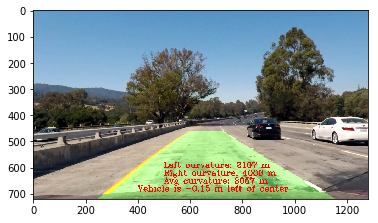

In [31]:
plt.imshow(pipeline(imgs_original["test1"]))

In [32]:
clip_output_filename = 'project_video_output.mp4'
clip_input = VideoFileClip('project_video.mp4')
clip_output = clip_input.fl_image(pipeline)
clip_output.write_videofile(clip_output_filename, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:09<00:00, 18.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

